# More context for FCNN

MoreStuff!!

In [ ]:
from ki_ueben.datasets import Maestro3Dataset, PianoRollDataset
from torch.utils.data import DataLoader

WINDOW_SIZE = 20

piano_roll_dataset = PianoRollDataset(
    midi_files=Maestro3Dataset().midi_file_paths,
    window_size=WINDOW_SIZE,
)

In [ ]:
context_data_loader = DataLoader(piano_roll_dataset, batch_size=32, num_workers=16)

In [ ]:
import lightning as L
from pytorch_lightning.utilities.model_summary import summarize
from torch import nn, optim


class ContextNet(L.LightningModule):
    def __init__(
        self,
        input_window_size: int = 20,
        num_input_dim: int = 88,
        num_output_dm: int = 88,
    ):
        super().__init__()
        self.input_window_size = input_window_size
        self.num_input_dim = num_input_dim
        self.num_output_dim = num_output_dm

        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.input_window_size * self.num_input_dim, 64, bias=True),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.Linear(64, 88, bias=True),
        )

    def training_step(self, batch, batch_idx):
        x, y = batch
        # scalar value needs to be put into a vector
        # x = x.unsqueeze(1)
        # y = y.unsqueeze(1)
        # z is the predicted note
        z = self.net(x)
        # print("x", x.shape, "y", y.shape, "z", z.shape)
        # we calculate the loss here
        loss = nn.functional.mse_loss(z, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        z = self.net(x)
        test_loss = nn.functional.mse_loss(z, y)
        self.log("test_loss", test_loss)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)


context_net = ContextNet()

print(context_net)

print("Summary:")
summarize(context_net)

ContextNet(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1760, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=64, bias=True)
    (6): Linear(in_features=64, out_features=88, bias=True)
  )
)
Summary:


  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 126 K  | train
--------------------------------------------
126 K     Trainable params
0         Non-trainable params
126 K     Total params
0.507     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode

In [ ]:
from pytorch_lightning.loggers import CSVLogger

simple_trainer = L.Trainer(
    max_epochs=5, logger=[CSVLogger(save_dir="logs", name="context_net", version=0)]
)
simple_trainer.fit(model=context_net, train_dataloaders=context_data_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/scheiba/github/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory logs/context_net/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 126 K  | train
--------------------------------------------
126 K     Trainable params
0         Non-trainable params
126 K     Total params
0.507     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
/Users/scheiba/github/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worke

Epoch 0: |          | 3/? [00:00<00:00,  6.02it/s, v_num=0, train_loss=168.0]

/var/folders/v0/7q67mljd4v9_frk_1p_mr2ph0000gn/T/ipykernel_20717/3724257029.py:31: UserWarning: Using a target size (torch.Size([32, 1, 88])) that is different to the input size (torch.Size([32, 88])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(z, y)


Epoch 0: |          | 14629/? [02:54<00:00, 83.95it/s, v_num=0, train_loss=122.0]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

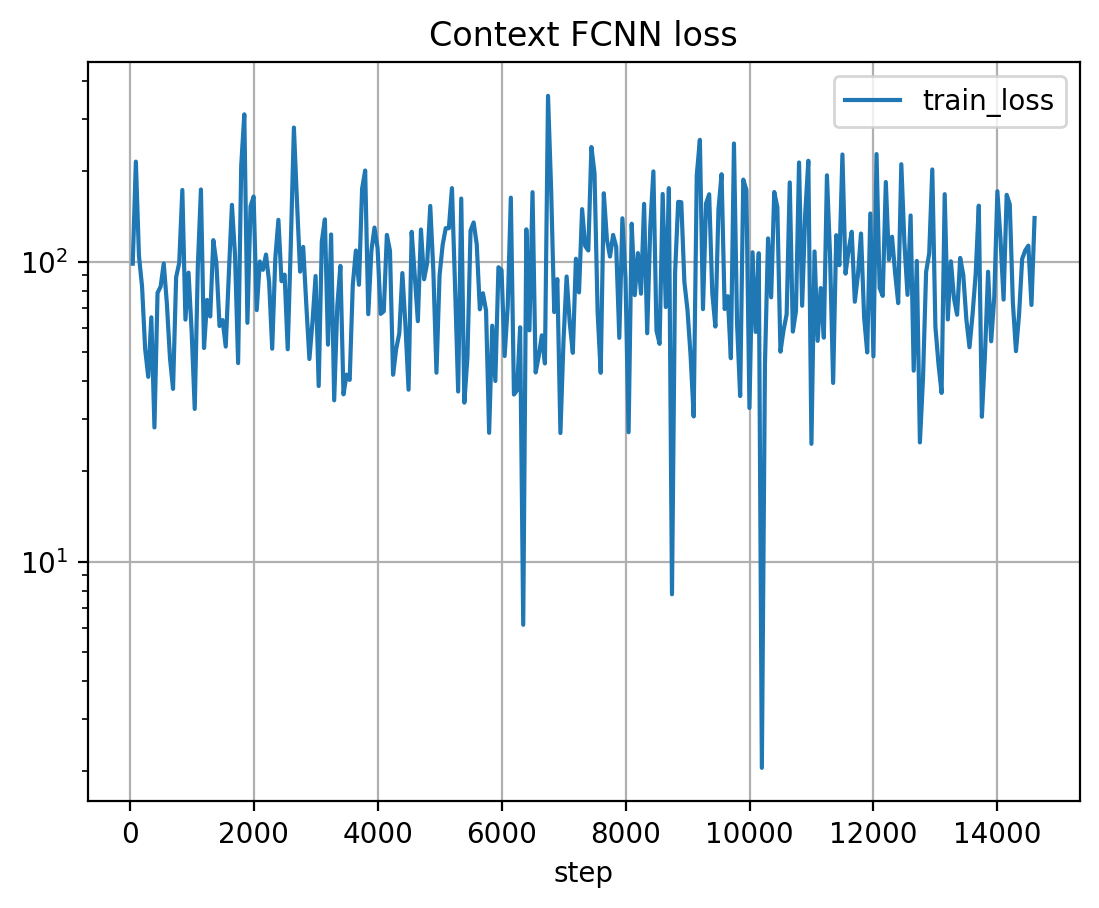

In [ ]:
import pandas as pd

df_simple_metrics = pd.read_csv("logs/context_net/version_0/metrics.csv")
df_simple_metrics.plot.line(
    grid=True, title="Context FCNN loss", x="step", y="train_loss", logy=True
);